In [ ]:
# This file is just for analysis and seeing the result. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install Pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install mlxtend==0.17.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [6]:
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os
from PIL import Image
from torchvision import transforms
import torch
from torchvision.models import vgg16
import glob
import torch.nn as nn
from skimage import measure
from mlxtend.frequent_patterns import fpgrowth
import matplotlib.pyplot as plt
import pandas as pd


In [9]:
# Hyper_parameter

alpha = 0.1 # α is used for balancing the effect of global and local features, Range - {0, 0.01, 0.1, · · · , 100}

k = 5 # Get top K images

minsupp = 2 # minimum support threshold for FPM, The range of minsupp are {0, 1, 2, · · · , 10}

In [10]:


class GlobalFeature:
    def __init__(self, vgg16):
        self.vgg16 = vgg16

    def extract(self, image):
        with torch.no_grad():
            features = self.vgg16.features(image)

        # Obtain the salient object by performing a mask operation
        features = features.squeeze(0)
        A = features.sum(dim=0)
        threshold = A.mean()
        mask = (A > threshold).float()

        # Retain the largest connected component using the flood fill algorithm
        labels = measure.label(mask.cpu().numpy())
        largest_label = labels.max()
        if largest_label > 0:
            largest_area = 0
            for i in range(1, largest_label + 1):
                area = (labels == i).sum()
                if area > largest_area:
                    largest_area = area
                    largest_component = i

        for i in range(mask.shape[0]):
            for j in range(mask.shape[1]):
                if labels[i, j] != largest_component:
                    mask[i, j] = 0

        mask = mask.unsqueeze(0).unsqueeze(0)
        salient_object = features * mask

        # Extract the global feature fG from the salient object
        fG_max_pooling = nn.functional.adaptive_max_pool2d(salient_object, (1, 1)).view(-1)
        fG_avg_pooling = nn.functional.adaptive_avg_pool2d(salient_object, (1, 1)).view(-1)
        fG = torch.cat((fG_max_pooling, fG_avg_pooling), dim=0)

        return fG

In [11]:


class LocalFeature:
    def __init__(self, vgg16):
        self.vgg16 = vgg16

    def extract(self, image):
        with torch.no_grad():
            features = self.vgg16.features(image)

        # Obtain the salient object by performing a mask operation
        features = features.squeeze(0)
        A = features.sum(dim=0)
        threshold = A.mean()
        mask = (A > threshold).float()
        mask = mask.unsqueeze(0).unsqueeze(0)
        salient_object = features * mask
        salient_object = salient_object.squeeze(0)

        # Convert feature maps and activated positions into transactions and items
        transactions = []
        for i in range(salient_object.shape[0]):
            feature_map = salient_object[i]
            activated_positions = (feature_map > 0).nonzero(as_tuple=True)
            items = [f'({x},{y})' for x, y in zip(*activated_positions)]
            transactions.append(items)

        # Mine frequent patterns using FPM
        
        I = sorted(set(item for transaction in transactions for item in transaction))
        df = pd.DataFrame([[int(item in transaction) for item in I] for transaction in transactions], columns=I)
        frequent_itemsets = fpgrowth(df, min_support=minsupp/len(transactions), use_colnames=True)

        # Extract the local feature fL from the frequent patterns
        patterns = torch.zeros_like(salient_object)
        for itemset in frequent_itemsets['itemsets']:
            for item in itemset:
                x, y = map(int, item.strip('()').split(','))
                patterns[:, x, y] = 1

        fL_max_pooling = nn.functional.adaptive_max_pool2d(patterns, (1, 1)).view(-1)
        fL_avg_pooling = nn.functional.adaptive_avg_pool2d(patterns, (1, 1)).view(-1)
        fL = torch.cat((fL_max_pooling, fL_avg_pooling), dim=0)

        return fL

In [12]:
def similarity_score(feature1, feature2):
    score = torch.dot(feature1, feature2) / (torch.norm(feature1) * torch.norm(feature2))
    return score.item()

In [13]:
def average_precision(retrieved_items, relevant_items):
    rel_count = 0
    precisions = []

    for i, item in enumerate(retrieved_items, start=1):
        if item in relevant_items:
            rel_count += 1
            precision_at_i = rel_count / i
            precisions.append(precision_at_i)

    if precisions:
        avg_precision = sum(precisions) / len(precisions)
    else:
        avg_precision = 0.0

    return avg_precision

In [14]:
def mean_average_precision(ap_scores):
    map_score = sum(ap_scores) / len(ap_scores)
    return map_score

In [15]:

# Define paths to query and database image folders
query_image_path = r"/content/drive/MyDrive/Colab Notebooks/database_new_new/002.Laysan_Albatross/Laysan_Albatross_0055_570.jpg"
database_image_folder = r"/content/drive/MyDrive/Colab Notebooks/database_new_new"
relevant_image_folder =  r"/content/drive/MyDrive/Colab Notebooks/database_new_new/002.Laysan_Albatross"



In [19]:
vgg16_model = vgg16(pretrained=True)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 194MB/s]


In [20]:

# Define image transformation
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: image.convert('RGB') if image.mode != 'RGB' else image),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

query_image = Image.open(query_image_path)
query_image = transform(query_image)



In [59]:
query_name = query_image_path.split('/')[-1]

In [60]:
query_name

'Laysan_Albatross_0055_570.jpg'

In [64]:

def load_and_transform_images(database_image_folder, transform, query_name):
    # Define image extensions
    image_extensions = ['jpg', 'png', 'jpeg']

    database_filenames = []
    database_images = []
    database_file_path = []

    # Iterate over all subdirectories and files in the root directory
    for subdir, dirs, files in os.walk(database_image_folder):
        for filename in files:
            # Check if the file is an image
            if filename.split('.')[-1].lower() in image_extensions:
                # Append the filename to the filenames list
                if filename == query_name:
                  continue
                database_filenames.append(filename)
                # Open and transform the image, then append it to the images list
                file_path = os.path.join(subdir, filename)
                database_file_path.append(file_path)
                with Image.open(os.path.join(subdir, filename)) as image:
                    try:
                        tensor_image = transform(image)
                        database_images.append(tensor_image)
                    except Exception as e:
                        print(f"Error transforming image {filename}: {str(e)}")

    # Convert the list of images into a torch tensor
    try:
        database_images = torch.stack(database_images)
    except Exception as e:
        print(f"Error in stacking images: {str(e)}")

    return database_filenames, database_images, database_file_path


In [65]:
database_filenames, database_images, database_file_path  = load_and_transform_images(database_image_folder, transform, query_name)

In [66]:

def get_image_names_from_folder(root_folder):
    image_extensions = ['jpg', 'png', 'gif', 'jpeg']
    image_names = []

    for ext in image_extensions:
        image_paths = glob.glob(f'{root_folder}/**/*.{ext}', recursive=True)
        for path in image_paths:
            image_name = os.path.basename(path)
            image_names.append(image_name)

    return image_names

relevant_images = get_image_names_from_folder(relevant_image_folder)



In [67]:
global_extractor = GlobalFeature(vgg16_model)
query_global_feature = global_extractor.extract(query_image)
local_extractor = LocalFeature(vgg16_model)
query_local_feature = global_extractor.extract(query_image)

query_features = query_global_feature + alpha * query_local_feature



In [68]:

all_similarity_score = []

for i,j in zip(database_filenames, database_images):
    file_name = i
    image = j
    global_feature = global_extractor.extract(image)
    local_feature = global_extractor.extract(image)
    database_feature =  global_feature + alpha * local_feature
    get_similarity = similarity_score(database_feature, query_features)
    all_similarity_score.append(get_similarity)




In [69]:

def get_top_k_indices(input_list, k):
    return sorted(range(len(input_list)), key=lambda i: input_list[i], reverse=True)[:k]

top_k_indices = get_top_k_indices(all_similarity_score, k)

top_k_results_path = [database_file_path[indices]  for indices in top_k_indices]
top_k_results = [database_filenames[indices]  for indices in top_k_indices]




In [70]:
one_average_precision = average_precision(top_k_results, relevant_images)

In [71]:
top_k_results

['Sooty_Albatross_0043_1076.jpg',
 'Black_Footed_Albatross_0060_796076.jpg',
 'Black_Footed_Albatross_0057_796106.jpg',
 'Sooty_Albatross_0044_1105.jpg',
 'Laysan_Albatross_0003_1033.jpg']

In [72]:
relevant_images

['Laysan_Albatross_0096_673.jpg',
 'Laysan_Albatross_0039_924.jpg',
 'Laysan_Albatross_0029_482.jpg',
 'Laysan_Albatross_0044_784.jpg',
 'Laysan_Albatross_0100_735.jpg',
 'Laysan_Albatross_0068_726.jpg',
 'Laysan_Albatross_0040_472.jpg',
 'Laysan_Albatross_0073_927.jpg',
 'Laysan_Albatross_0051_1020.jpg',
 'Laysan_Albatross_0076_671.jpg',
 'Laysan_Albatross_0047_619.jpg',
 'Laysan_Albatross_0055_570.jpg',
 'Laysan_Albatross_0061_563.jpg',
 'Laysan_Albatross_0071_792.jpg',
 'Laysan_Albatross_0081_800.jpg',
 'Laysan_Albatross_0056_500.jpg',
 'Laysan_Albatross_0005_565.jpg',
 'Laysan_Albatross_0065_809.jpg',
 'Laysan_Albatross_0092_834.jpg',
 'Laysan_Albatross_0003_1033.jpg',
 'Laysan_Albatross_0018_492.jpg',
 'Laysan_Albatross_0006_702.jpg',
 'Laysan_Albatross_0085_564.jpg',
 'Laysan_Albatross_0099_869.jpg',
 'Laysan_Albatross_0083_756.jpg',
 'Laysan_Albatross_0088_883.jpg',
 'Laysan_Albatross_0050_870.jpg',
 'Laysan_Albatross_0013_910.jpg',
 'Laysan_Albatross_0094_1013.jpg',
 'Laysan_Al

In [73]:
top_k_results

['Sooty_Albatross_0043_1076.jpg',
 'Black_Footed_Albatross_0060_796076.jpg',
 'Black_Footed_Albatross_0057_796106.jpg',
 'Sooty_Albatross_0044_1105.jpg',
 'Laysan_Albatross_0003_1033.jpg']

In [74]:
one_average_precision 


0.2

In [75]:
query_image_path

'/content/drive/MyDrive/Colab Notebooks/database_new_new/002.Laysan_Albatross/Laysan_Albatross_0055_570.jpg'

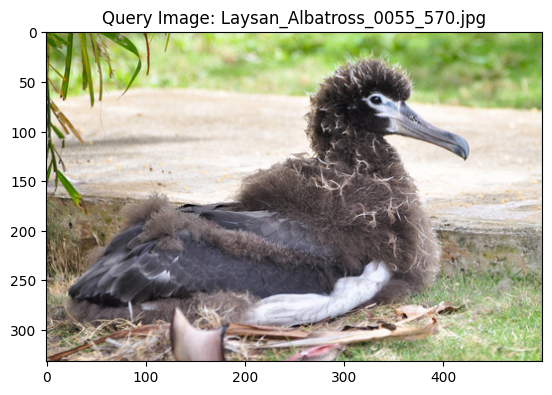

In [76]:
# query image
img = Image.open(query_image_path)
image_name = os.path.basename(query_image_path)
plt.imshow(img)
plt.title(f"Query Image: {image_name}")
plt.show()

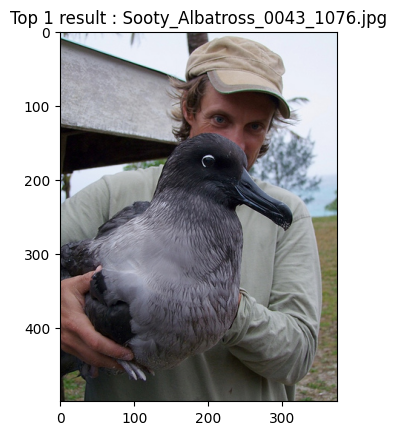

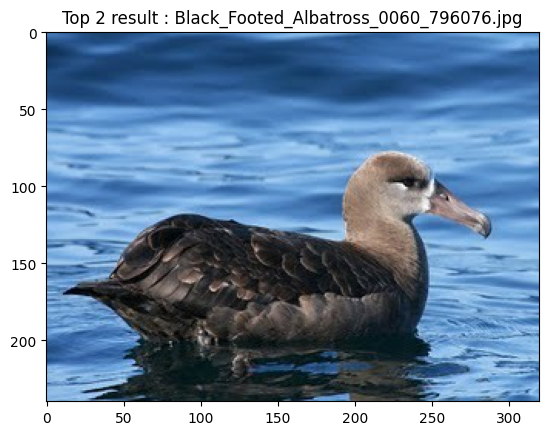

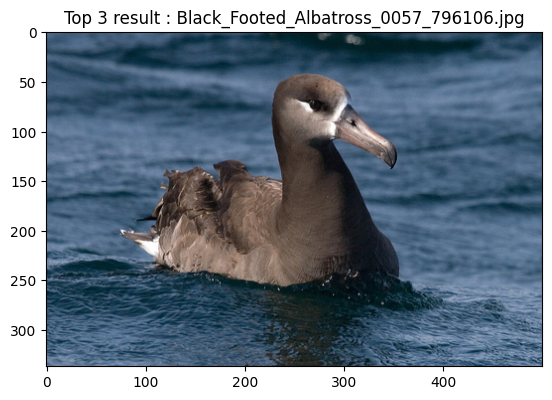

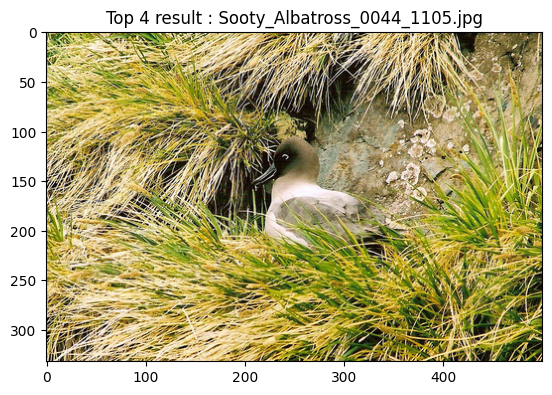

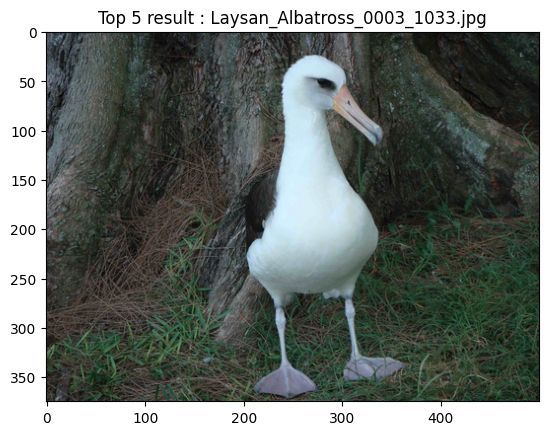

In [77]:
# Open and display each image
for i, path in enumerate(top_k_results_path):
    image_name = os.path.basename(path)
    img = Image.open(path)
    plt.imshow(img)
    plt.title(f'Top {i+1} result : {image_name}')  # Add a title to the image
    plt.show()
    print("\n")